In [1]:
import os
import pickle
import torch

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from cl_explain.metrics.ablation import compute_auc

In [2]:
result_path = "/projects/leelab/cl-explainability/results/imagenette2/simclr_x1"
attribution_methods = ["int_grad", "vanilla_grad", "random_baseline"]
explanation_methods = ["self_weighted", "contrastive_self_weighted", "corpus", "contrastive_corpus"]

explanation_filenames = {
    "self_weighted": "eval_results_explicand_size=100_removal=blurring_blur_strength=5.0_eval_superpixel_dim=1_eval_foil_size=500.pkl",
    "contrastive_self_weighted": "eval_results_explicand_size=100_foil_size=500_removal=blurring_blur_strength=5.0_eval_superpixel_dim=1_eval_foil_size=500.pkl",
    "corpus": "eval_results_explicand_size=100_corpus_size=100_removal=blurring_blur_strength=5.0_eval_superpixel_dim=1_eval_foil_size=500.pkl",
    "contrastive_corpus": "eval_results_explicand_size=100_corpus_size=100_foil_size=500_removal=blurring_blur_strength=5.0_eval_superpixel_dim=1_eval_foil_size=500.pkl",
}

attribution_colors = {
    "gradient_shap": "tab:red",
    "int_grad": "tab:orange",
    "vanilla_grad": "tab:blue",
    "random_baseline": "tab:green",
}
explanation_linestyles = {
    "self_weighted": "dotted",
    "contrastive_self_weighted": "dashed",
    "corpus": "dashdot",
    "contrastive_corpus": "solid",
}


def format_eval_name(name):
    format_map = {
        "corpus_cosine_similarity": "Cosine similarity to corpus",
        "contrastive_corpus_cosine_similarity": "Cosine similarity to corpus vs. foil",
        "corpus_majority_prob": "Predicted probability of corpus majority",
        "explicand_pred_prob": "Predicted probability of explicand",
        "explicand_rep_shift": "Representation shift of explicand",
    }
    return format_map[name]


def format_explanation_name(name):
    format_map = {
        "self_weighted": "Labe-Free",
        "contrastive_self_weighted": "Contrastive",
        "corpus": "Corpus",
        "contrastive_corpus": "Contrastive Corpus",
    }
    return format_map[name]


def format_attribution_name(name):
    format_map = {
        "gradient_shap": "Gradient Shap",
        "int_grad": "Integrated Gradient",
        "vanilla_grad": "Vanilla Gradient",
        "random_baseline": "Random",
    }
    return format_map[name]

In [3]:
def plot_results(plot_std: bool = False, plot_abs: bool = False):
    fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(32, 12))
    random_baseline_plotted = False

    for explanation in explanation_methods:
        for attribution in attribution_methods:
            make_plot = True
            if attribution == "random_baseline" and random_baseline_plotted:
                make_plot = False

            if make_plot:
                method = f"{explanation}_{attribution}"
                if attribution == "random_baseline":
                    method_name = "Random"
                else:
                    method_name = (
                        format_explanation_name(explanation)
                        + " "
                        + format_attribution_name(attribution)
                    )
                if plot_abs:
                    method_name += " (Abs)"

                filename = explanation_filenames[explanation]
                if plot_abs:
                    filename = filename.replace(".pkl", "_abs.pkl")
                with open(
                    os.path.join(
                        result_path,
                        method,
                        "123",
                        filename,
                    ),
                    "rb"
                ) as handle:
                    outputs = pickle.load(handle)

                eval_names = outputs[0]["eval_model_names"] + outputs[0]["eval_measure_names"]
                for j, eval_name in enumerate(eval_names):

                    insertion_curves_list = []
                    deletion_curves_list = []
                    insertion_num_features = None
                    deletion_num_features = None

                    for target, results in outputs.items():
                        all_insertion_curve_list = results["model_insertion_curves"] + results["measure_insertion_curves"]
                        all_deletion_curve_list = results["model_deletion_curves"] + results["measure_deletion_curves"]
                        
                        insertion_curves_list.append(all_insertion_curve_list[j])
                        deletion_curves_list.append(all_deletion_curve_list[j])
                        insertion_num_features = results["insertion_num_features"]
                        deletion_num_features = results["deletion_num_features"]
                        formatted_eval_name = format_eval_name(eval_name)

                    insertion_curves = torch.cat(insertion_curves_list)
                    deletion_curves = torch.cat(deletion_curves_list)

                    insertion_curve_mean = insertion_curves.mean(dim=0).cpu()
                    insertion_curve_std = insertion_curves.std(dim=0).cpu()
                    deletion_curve_mean = deletion_curves.mean(dim=0).cpu()
                    deletion_curve_std = deletion_curves.std(dim=0).cpu()
                    
                    insertion_auc = compute_auc(
                        insertion_curve_mean.unsqueeze(0), insertion_num_features
                    )
                    insertion_auc = float(insertion_auc)
                    deletion_auc = compute_auc(
                        deletion_curve_mean.unsqueeze(0), deletion_num_features
                    )
                    deletion_auc = float(deletion_auc)

                    axes[0, j].plot(
                        insertion_num_features,
                        insertion_curve_mean,
                        label=method_name + "; AUC = {:.3f}".format(insertion_auc),
                        color=attribution_colors[attribution],
                        linestyle=explanation_linestyles[explanation],
                    )
                    if plot_std:
                        axes[0, j].fill_between(
                            insertion_num_features,
                            insertion_curve_mean - insertion_curve_std,
                            insertion_curve_mean + insertion_curve_std,
                            alpha=0.1,
                        )
                    axes[0, j].set_title(f"Insertion curve: {formatted_eval_name}")
                    axes[0, j].set_xlabel("Number of pixels inserted")
                    axes[0, j].set_ylabel(f"{formatted_eval_name}")
                    axes[0, j].legend()

                    axes[1, j].plot(
                        deletion_num_features,
                        deletion_curve_mean,
                        label=method_name + "; AUC = {:.3f}".format(deletion_auc),
                        color=attribution_colors[attribution],
                        linestyle=explanation_linestyles[explanation],
                    )
                    if plot_std:
                        axes[1, j].fill_between(
                            deletion_num_features,
                            deletion_curve_mean - deletion_curve_std,
                            deletion_curve_mean + deletion_curve_std,
                            alpha=0.1,
                        )
                    axes[1, j].set_title(f"Deletion curve: {formatted_eval_name}")
                    axes[1, j].set_xlabel("Number of pixels deleted")
                    axes[1, j].set_ylabel(f"{formatted_eval_name}")
                    axes[1, j].legend()
            else:
                pass
            if attribution == "random_baseline":
                random_baseline_plotted = True
    plt.tight_layout()

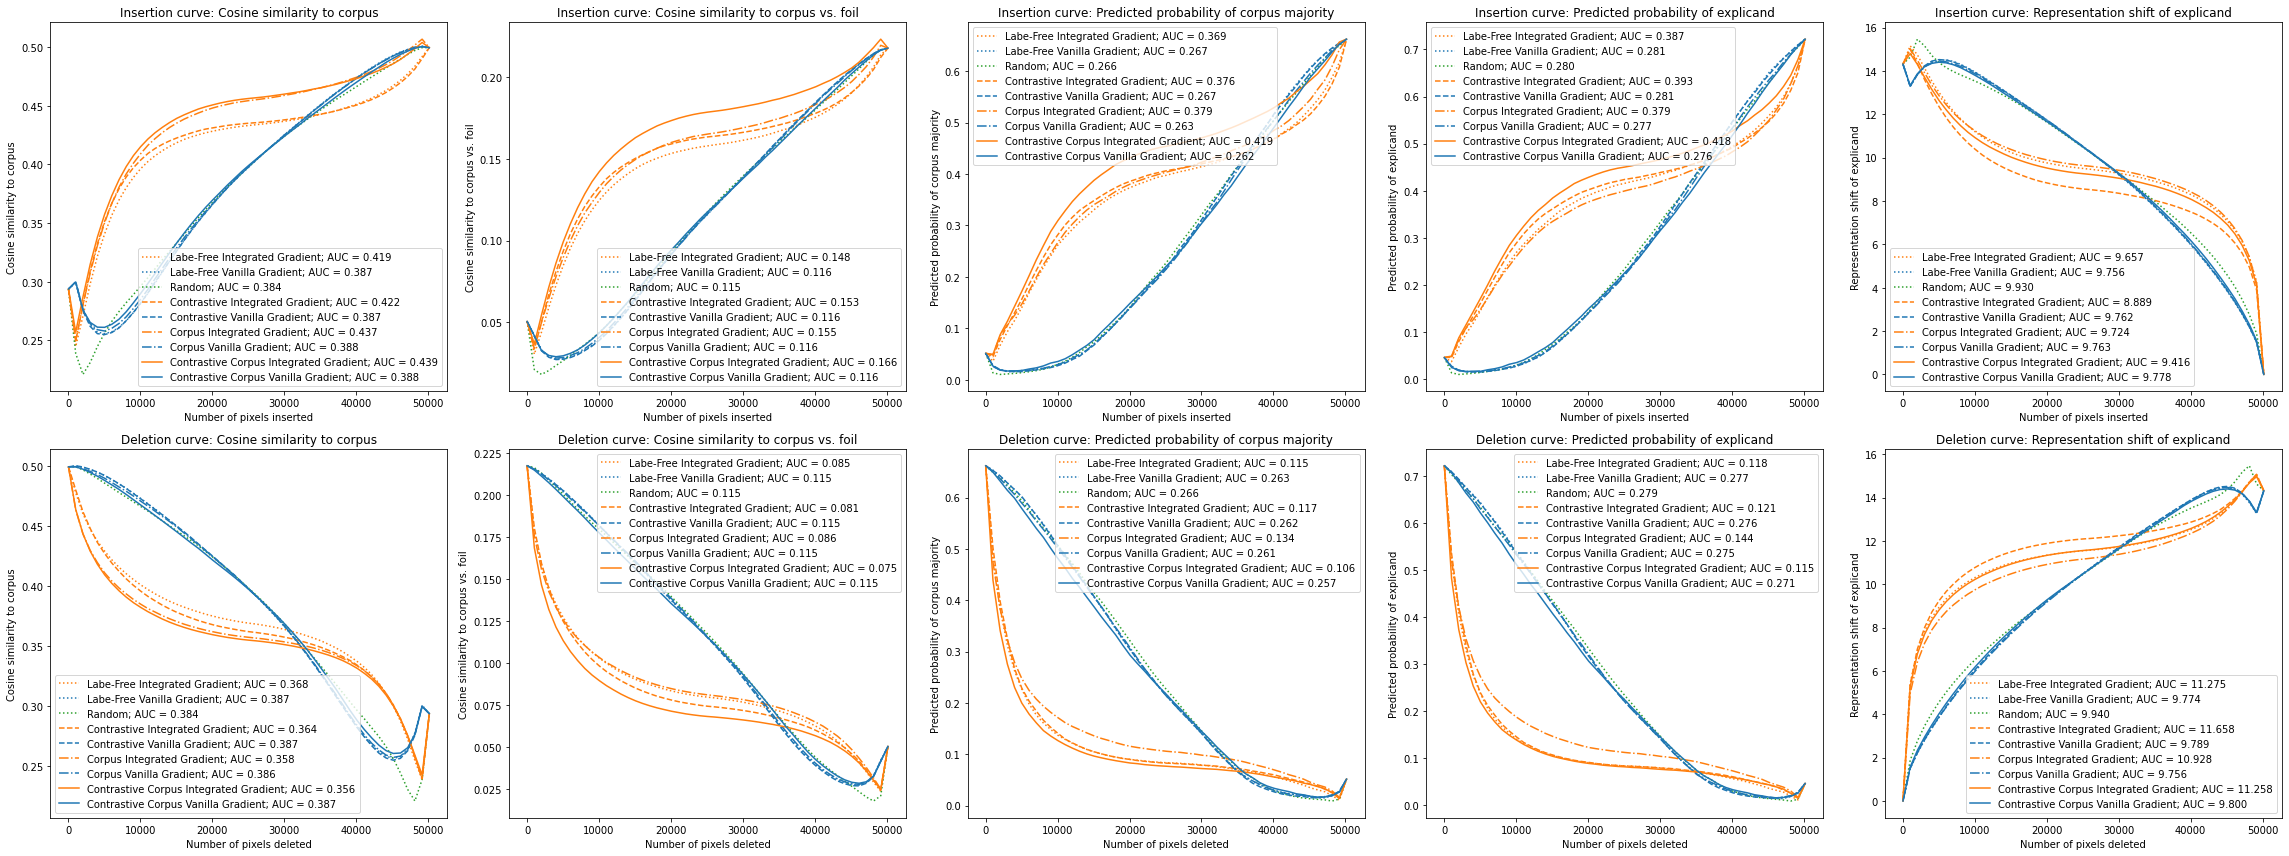

In [4]:
plot_results()

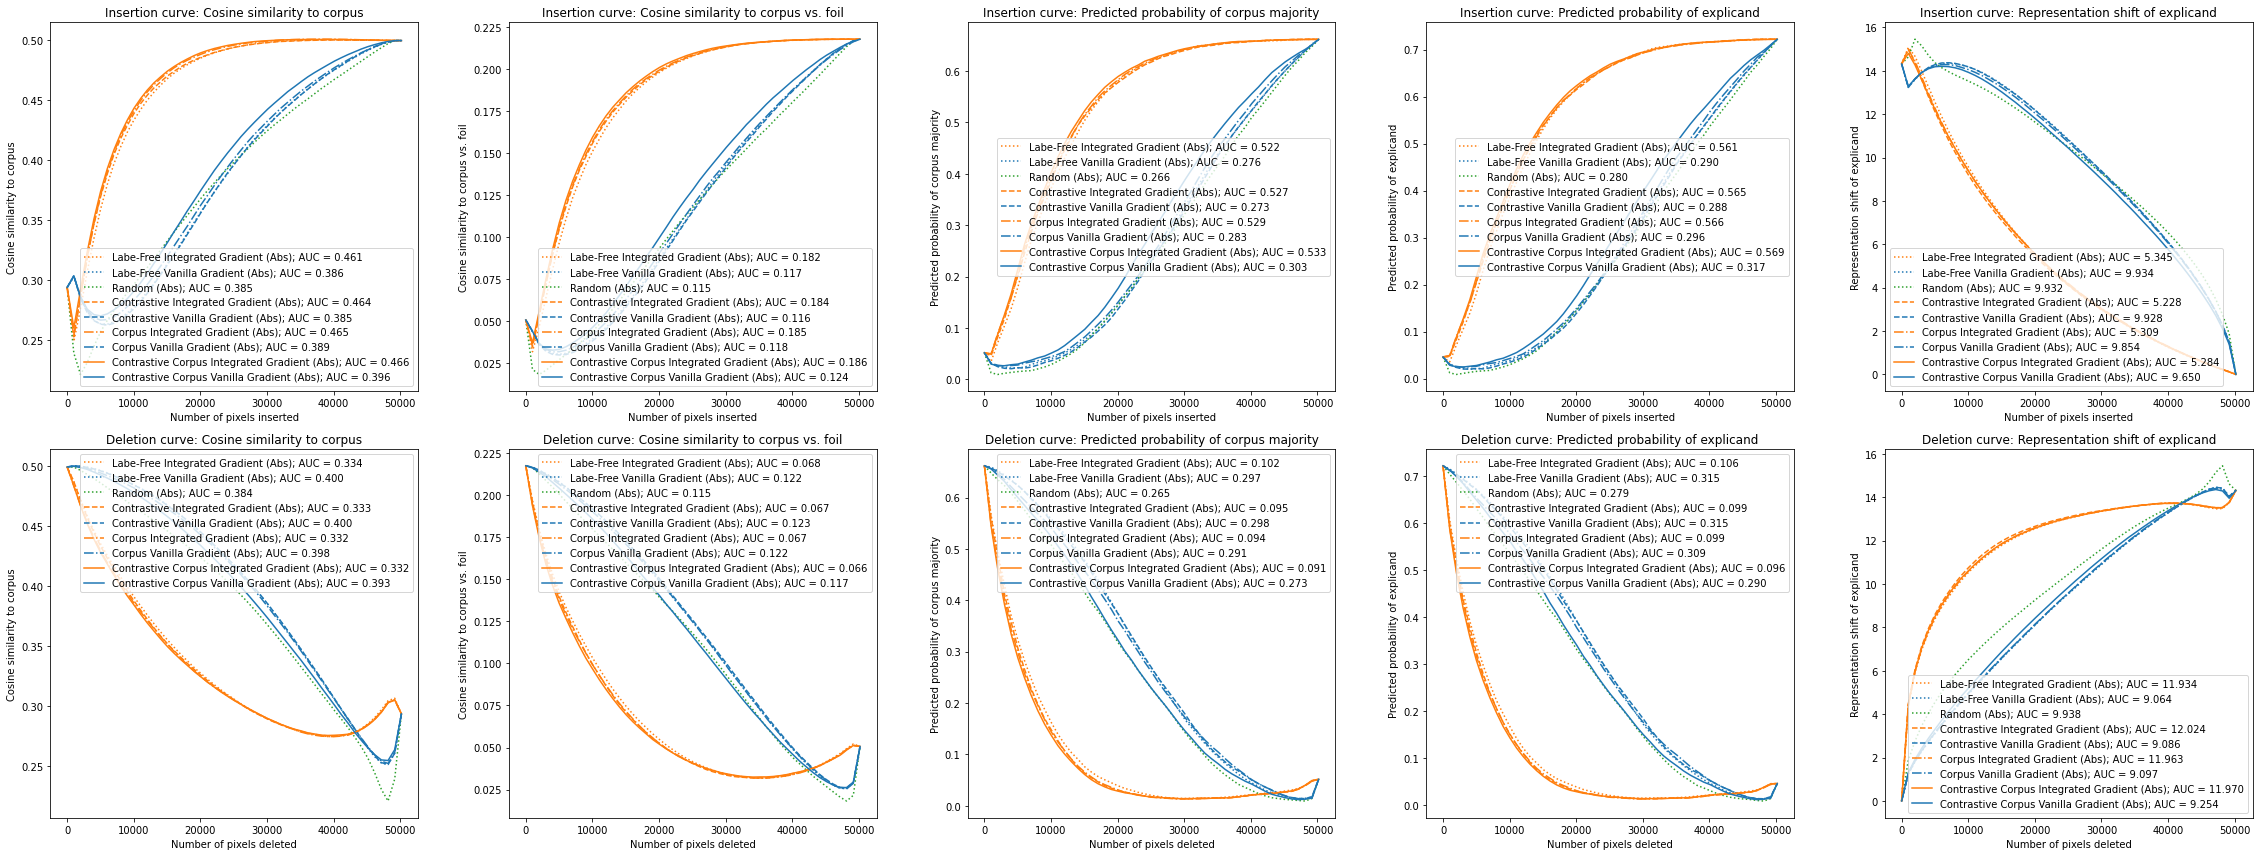

In [5]:
plot_results(plot_abs=True)

In [6]:
gini_df_list = []
auc_df_list = []

for attribution in attribution_methods:
    for explanation in explanation_methods:
        filename = explanation_filenames[explanation]
        method = f"{explanation}_{attribution}"
        with open(
            os.path.join(
                result_path,
                method,
                "123",
                filename,
            ),
            "rb"
        ) as handle:
            outputs = pickle.load(handle)
        
        for target, results in outputs.items():
            gini_df = pd.DataFrame({"gini": results["gini_indices"]})
            gini_df["attribution"] = attribution
            gini_df["explanation"] = explanation
            gini_df["target"] = target
            gini_df_list.append(gini_df)
            
            metric_list = results["eval_model_names"] + results["eval_measure_names"]
            
            for ablation in ["insertion", "deletion"]:
                auc_list = results[f"model_{ablation}_aucs"] + results[f"measure_{ablation}_aucs"]
                
                for j, metric in enumerate(metric_list):
                    auc_df = pd.DataFrame({"auc": auc_list[j]})
                    auc_df["attribution"] = attribution
                    auc_df["explanation"] = explanation
                    auc_df["target"] = target
                    auc_df["ablation"] = ablation
                    auc_df["metric"] = metric
                    auc_df_list.append(auc_df)

gini_df = pd.concat(gini_df_list, ignore_index=True)
auc_df = pd.concat(auc_df_list, ignore_index=True)

In [7]:
gini_summary_df = gini_df.groupby(
    ["attribution", "explanation"], as_index=False
)["gini"].mean()

In [8]:
# Higher Gini Index -> higher sparsity.
gini_summary_df.sort_values(by="gini", ascending=False).sort_values(by="attribution")

,attribution,explanation,gini
0,int_grad,contrastive_corpus,0.676617
1,int_grad,contrastive_self_weighted,0.667080
2,int_grad,corpus,0.665155
3,int_grad,self_weighted,0.657506
5,random_baseline,contrastive_self_weighted,0.414212
6,random_baseline,corpus,0.414212
7,random_baseline,self_weighted,0.414191
4,random_baseline,contrastive_corpus,0.414164
8,vanilla_grad,contrastive_corpus,0.590160
10,vanilla_grad,corpus,0.584009


In [9]:
auc_summary_df = auc_df.groupby(
    ["metric", "attribution", "ablation", "explanation"], as_index=False
)["auc"].mean()
auc_summary_df = auc_summary_df[["metric", "ablation", "attribution", "explanation", "auc"]]

In [10]:
auc_summary_df[
    (auc_summary_df["metric"] == "explicand_pred_prob")
    & (auc_summary_df["ablation"] == "insertion")
].sort_values(by="auc", ascending=False).sort_values(by="attribution")

,metric,ablation,attribution,explanation,auc
76,explicand_pred_prob,insertion,int_grad,contrastive_corpus,0.418200
77,explicand_pred_prob,insertion,int_grad,contrastive_self_weighted,0.393385
79,explicand_pred_prob,insertion,int_grad,self_weighted,0.387102
78,explicand_pred_prob,insertion,int_grad,corpus,0.378663
87,explicand_pred_prob,insertion,random_baseline,self_weighted,0.279747
84,explicand_pred_prob,insertion,random_baseline,contrastive_corpus,0.279507
85,explicand_pred_prob,insertion,random_baseline,contrastive_self_weighted,0.278622
86,explicand_pred_prob,insertion,random_baseline,corpus,0.278622
93,explicand_pred_prob,insertion,vanilla_grad,contrastive_self_weighted,0.280922
95,explicand_pred_prob,insertion,vanilla_grad,self_weighted,0.280742


In [11]:
auc_summary_df[
    (auc_summary_df["metric"] == "corpus_majority_prob")
    & (auc_summary_df["ablation"] == "insertion")
].sort_values(by="auc", ascending=False).sort_values(by="attribution")

,metric,ablation,attribution,explanation,auc
52,corpus_majority_prob,insertion,int_grad,contrastive_corpus,0.418752
54,corpus_majority_prob,insertion,int_grad,corpus,0.379240
53,corpus_majority_prob,insertion,int_grad,contrastive_self_weighted,0.375709
55,corpus_majority_prob,insertion,int_grad,self_weighted,0.368609
63,corpus_majority_prob,insertion,random_baseline,self_weighted,0.266221
60,corpus_majority_prob,insertion,random_baseline,contrastive_corpus,0.265763
61,corpus_majority_prob,insertion,random_baseline,contrastive_self_weighted,0.265225
62,corpus_majority_prob,insertion,random_baseline,corpus,0.265225
71,corpus_majority_prob,insertion,vanilla_grad,self_weighted,0.266781
69,corpus_majority_prob,insertion,vanilla_grad,contrastive_self_weighted,0.266664


In [12]:
auc_summary_df[
    (auc_summary_df["metric"] == "explicand_rep_shift")
    & (auc_summary_df["ablation"] == "insertion")
].sort_values(by="auc", ascending=False).sort_values(by="attribution")

,metric,ablation,attribution,explanation,auc
102,explicand_rep_shift,insertion,int_grad,corpus,9.724094
103,explicand_rep_shift,insertion,int_grad,self_weighted,9.657103
100,explicand_rep_shift,insertion,int_grad,contrastive_corpus,9.416196
101,explicand_rep_shift,insertion,int_grad,contrastive_self_weighted,8.888719
109,explicand_rep_shift,insertion,random_baseline,contrastive_self_weighted,9.938313
110,explicand_rep_shift,insertion,random_baseline,corpus,9.938313
111,explicand_rep_shift,insertion,random_baseline,self_weighted,9.930470
108,explicand_rep_shift,insertion,random_baseline,contrastive_corpus,9.923951
116,explicand_rep_shift,insertion,vanilla_grad,contrastive_corpus,9.778424
118,explicand_rep_shift,insertion,vanilla_grad,corpus,9.762773


In [13]:
auc_summary_df[
    (auc_summary_df["metric"] == "explicand_pred_prob")
    & (auc_summary_df["ablation"] == "deletion")
].sort_values(by="auc", ascending=False).sort_values(by="attribution")

,metric,ablation,attribution,explanation,auc
74,explicand_pred_prob,deletion,int_grad,corpus,0.144429
73,explicand_pred_prob,deletion,int_grad,contrastive_self_weighted,0.120957
75,explicand_pred_prob,deletion,int_grad,self_weighted,0.117883
72,explicand_pred_prob,deletion,int_grad,contrastive_corpus,0.114749
81,explicand_pred_prob,deletion,random_baseline,contrastive_self_weighted,0.280370
82,explicand_pred_prob,deletion,random_baseline,corpus,0.280370
80,explicand_pred_prob,deletion,random_baseline,contrastive_corpus,0.280300
83,explicand_pred_prob,deletion,random_baseline,self_weighted,0.279492
91,explicand_pred_prob,deletion,vanilla_grad,self_weighted,0.277065
89,explicand_pred_prob,deletion,vanilla_grad,contrastive_self_weighted,0.276016


In [14]:
auc_summary_df[
    (auc_summary_df["metric"] == "corpus_majority_prob")
    & (auc_summary_df["ablation"] == "deletion")
].sort_values(by="auc", ascending=False).sort_values(by="attribution")

,metric,ablation,attribution,explanation,auc
50,corpus_majority_prob,deletion,int_grad,corpus,0.134024
49,corpus_majority_prob,deletion,int_grad,contrastive_self_weighted,0.117312
51,corpus_majority_prob,deletion,int_grad,self_weighted,0.114563
48,corpus_majority_prob,deletion,int_grad,contrastive_corpus,0.106482
56,corpus_majority_prob,deletion,random_baseline,contrastive_corpus,0.266667
57,corpus_majority_prob,deletion,random_baseline,contrastive_self_weighted,0.266218
58,corpus_majority_prob,deletion,random_baseline,corpus,0.266218
59,corpus_majority_prob,deletion,random_baseline,self_weighted,0.265757
67,corpus_majority_prob,deletion,vanilla_grad,self_weighted,0.263000
65,corpus_majority_prob,deletion,vanilla_grad,contrastive_self_weighted,0.262286


In [15]:
auc_summary_df[
    (auc_summary_df["metric"] == "explicand_rep_shift")
    & (auc_summary_df["ablation"] == "deletion")
].sort_values(by="auc", ascending=False).sort_values(by="attribution")

,metric,ablation,attribution,explanation,auc
97,explicand_rep_shift,deletion,int_grad,contrastive_self_weighted,11.658028
99,explicand_rep_shift,deletion,int_grad,self_weighted,11.274858
96,explicand_rep_shift,deletion,int_grad,contrastive_corpus,11.258399
98,explicand_rep_shift,deletion,int_grad,corpus,10.928248
107,explicand_rep_shift,deletion,random_baseline,self_weighted,9.939711
104,explicand_rep_shift,deletion,random_baseline,contrastive_corpus,9.932273
105,explicand_rep_shift,deletion,random_baseline,contrastive_self_weighted,9.926171
106,explicand_rep_shift,deletion,random_baseline,corpus,9.926171
112,explicand_rep_shift,deletion,vanilla_grad,contrastive_corpus,9.799696
113,explicand_rep_shift,deletion,vanilla_grad,contrastive_self_weighted,9.788704
